## Import Libraries

In [47]:
import os
import glob
import numpy as np
from PIL import Image
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
import random

from tensorflow.keras import layers, datasets, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, roc_curve, f1_score, classification_report, auc

 Define the paths to the train, test, and validation folders


In [16]:
train_folder = 'Downloads/archive/train/' 
test_folder = 'Downloads/archive/test/'  
val_folder = 'Downloads/archive/val/'  


Define the color labels


In [17]:
color_labels = ['beige',
 'black',
 'blue',
 'brown',
 'gold',
 'green',
 'grey',
 'orange',
 'pink',
 'purple',
 'red',
 'silver',
 'tan',
 'white',
 'yellow']

## Load and preprocess the training data


In [18]:
#Initialize empty lists to store the preprocessed images and their corresponding labels
train_images = []
train_labels = []
# Iterate over color labels
for color_label in color_labels:
    folder_path = os.path.join(train_folder, color_label) # construct the path to the folder containing images of the current color label.
    file_paths = glob.glob(os.path.join(folder_path, '*.jpg')) # find all file paths that match the pattern of '*.jpg' within the folder of the current color label.
    for file_path in file_paths:  # Iterate over each file path found in the previous step
        image = Image.open(file_path) # open the image file using the Image.open() function from the PIL
        image = image.resize((224, 224))  # Resize the image to a fixed size
        image = np.array(image) # covert the image a NumPy array
        train_images.append(image) # The preprocessed image is appended to the train_images list
        train_labels.append(color_labels.index(color_label)) # the corresponding label is appended to the train_labels list. The label is determined by finding the index of the current color label in the color_labels list.
# the train_images and train_labels lists are converted into NumPy arrays using np.array(), which is a common format for handling data in machine learning models.
train_images = np.array(train_images)
train_labels = np.array(train_labels)


In [19]:
# Check the size of images
print(np.min(train_images))
print(np.max(train_images))

# Normalize the pixel values to the range [0, 1]
train_images = train_images / 255.0

0
255


In [20]:
train_images.shape

(7267, 224, 224, 3)

In [21]:
train_images.dtype

dtype('float64')

In [22]:
print(np.min(train_images))
print(np.max(train_images))

0.0
1.0


In [23]:
train_labels.shape

(7267,)

The labels are the color classes, from 0 to 14:


In [24]:
train_labels

array([ 0,  0,  0, ..., 14, 14, 14])

We can plot an image using Matplotlib's imshow() function


(-0.5, 223.5, 223.5, -0.5)

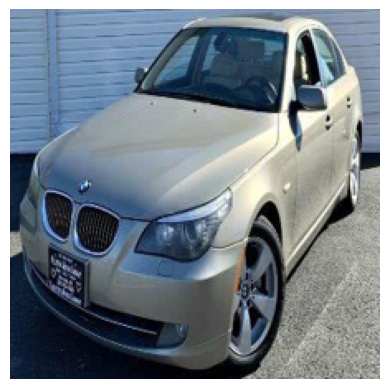

In [25]:
plt.imshow(train_images[0])
plt.axis('off')


So the first image in the training set has color beige:


In [26]:
color_labels[train_labels[0]]

'beige'

Let's take a look at a sample of the images in the dataset:


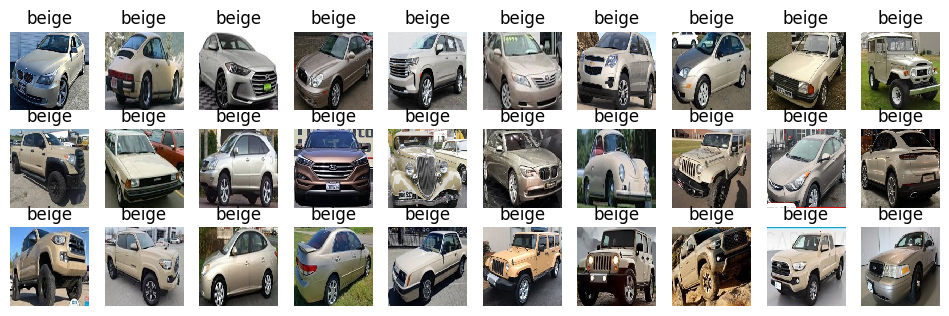

In [27]:
nrows = 3
ncols =10
plt.figure(figsize=(ncols*1.2, nrows*1.2))
for row in range(nrows):
    for col in range(ncols):
        index = ncols* row + col
        plt.subplot(nrows, ncols, index+1)
        plt.imshow(train_images[index], interpolation='nearest')
        plt.axis('off')
        plt.title(color_labels[train_labels[index]])
plt.show()

In [28]:
# Load and preprocess the validation data
val_images = []
val_labels = []
for color_label in color_labels:
    folder_path = os.path.join(val_folder, color_label)
    file_paths = glob.glob(os.path.join(folder_path, '*.jpg'))
    for file_path in file_paths:
        image = Image.open(file_path)
        image = image.resize((224, 224))  # Resize the image to a fixed size
        image = np.array(image)
        val_images.append(image)
        val_labels.append(color_labels.index(color_label))

val_images = np.array(val_images)
val_labels = np.array(val_labels)

In [29]:
# Normalize the pixel values to the range [0, 1]
val_images = val_images / 255.0

In [30]:
# Load and preprocess the test data
test_images = []
test_labels = []
for color_label in color_labels:
    folder_path = os.path.join(test_folder, color_label)
    file_paths = glob.glob(os.path.join(folder_path, '*.jpg'))
    for file_path in file_paths:
        image = Image.open(file_path)
        image = image.resize((224, 224))  # Resize the image to a fixed size
        image = np.array(image)
        test_images.append(image)
        test_labels.append(color_labels.index(color_label))

test_images = np.array(test_images)
test_labels = np.array(test_labels)

In [31]:
# Normalize the pixel values to the range [0, 1]
test_images = test_images / 255.0

## Create the convolutional base

The lines of code below define the convolutional base using a common pattern: 
The Keras Sequential model consists of convolution blocks (tf.keras.layers.Conv2D) with a max pooling layer (tf.keras.layers.MaxPooling2D) in each of them. There's a fully-connected layer (tf.keras.layers.Dense) on top of it that is activated by a ReLU activation function ('relu').

As input, a CNN takes tensors of shape (image_height, image_width, color_channels). We can do this by passing the argument input_shape to your first layer.

In [32]:
# Define the model architecture
model = keras.Sequential([
    keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(len(color_labels), activation='softmax')
])

## Compile and train the model


In [33]:
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [34]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 64)        36928     
                                                                 
 flatten (Flatten)           (None, 173056)            0

In [35]:
# Train the model
history= model.fit(train_images, train_labels, epochs=10,
                  validation_data=(val_images, val_labels))

Epoch 1/10
228/228 [==============================] - 339s 1s/step - loss: 1.3455 - accuracy: 0.5566 - val_loss: 0.9303 - val_accuracy: 0.6819
Epoch 2/10
228/228 [==============================] - 289s 1s/step - loss: 0.7480 - accuracy: 0.7387 - val_loss: 0.7862 - val_accuracy: 0.7368
Epoch 3/10
228/228 [==============================] - 322s 1s/step - loss: 0.6163 - accuracy: 0.7820 - val_loss: 0.7416 - val_accuracy: 0.7381
Epoch 4/10
228/228 [==============================] - 316s 1s/step - loss: 0.4902 - accuracy: 0.8316 - val_loss: 0.6903 - val_accuracy: 0.7677
Epoch 5/10
228/228 [==============================] - 280s 1s/step - loss: 0.3687 - accuracy: 0.8766 - val_loss: 0.8668 - val_accuracy: 0.7310
Epoch 6/10
228/228 [==============================] - 279s 1s/step - loss: 0.2307 - accuracy: 0.9267 - val_loss: 0.9987 - val_accuracy: 0.7187
Epoch 7/10
228/228 [==============================] - 280s 1s/step - loss: 0.1694 - accuracy: 0.9444 - val_loss: 0.8360 - val_accuracy: 0.7903

## Visualize training results


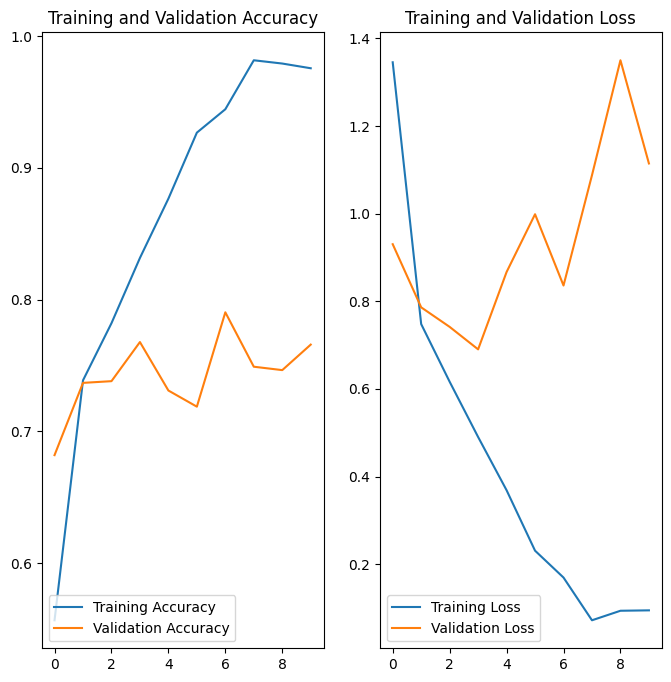

In [36]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss= history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2 ,1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower left')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label= "Training Loss")
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='lower left')
plt.title('Training and Validation Loss')
plt.show()

## Evaluating the model

In [37]:
model.evaluate(test_images, test_labels)

49/49 [==============================] - 20s 400ms/step - loss: 1.2104 - accuracy: 0.7590


[1.2104194164276123, 0.7589974403381348]

## Using the model to make predictions for few examples


In [50]:
X_new = test_images[:3]
# predicting a Probability vector
prediction_p = model.predict(X_new)

#To return an integer representing the predicted target, we want the index of the largest probability. This is accomplished with the Numpy argmax function.
y_pred = prediction_p.argmax(axis=-1)
y_pred

array([[[[0.19215686, 0.27843137, 0.08627451],
         [0.20392157, 0.29019608, 0.09803922],
         [0.18039216, 0.26666667, 0.0745098 ],
         ...,
         [0.19607843, 0.29019608, 0.10196078],
         [0.19607843, 0.29019608, 0.10196078],
         [0.18039216, 0.2745098 , 0.08627451]],

        [[0.18431373, 0.27058824, 0.07843137],
         [0.20392157, 0.29019608, 0.09803922],
         [0.18039216, 0.26666667, 0.0745098 ],
         ...,
         [0.18823529, 0.28235294, 0.09411765],
         [0.19215686, 0.28627451, 0.09803922],
         [0.18039216, 0.2745098 , 0.08627451]],

        [[0.16470588, 0.25098039, 0.05882353],
         [0.2       , 0.28627451, 0.09411765],
         [0.18431373, 0.27058824, 0.07843137],
         ...,
         [0.16862745, 0.2627451 , 0.0745098 ],
         [0.17647059, 0.2745098 , 0.08627451],
         [0.18823529, 0.28235294, 0.09411765]],

        ...,

        [[0.62352941, 0.59607843, 0.55686275],
         [0.64705882, 0.61960784, 0.58039216]

true labels of examples

In [40]:
y_new = test_labels[:3]
y_new

array([0, 0, 0])

Let's compare the predictions vs the labels for our examples

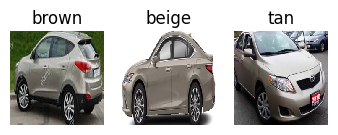

In [41]:
plt.figure(figsize=(7, 2))
for index, image in enumerate(X_new):
    plt.subplot(1, 5, index+1)
    plt.imshow(image, interpolation='nearest')
    plt.axis('off')
    plt.title(color_labels[y_pred[index]])
plt.show()

1/1 [==============================] - 0s 359ms/step


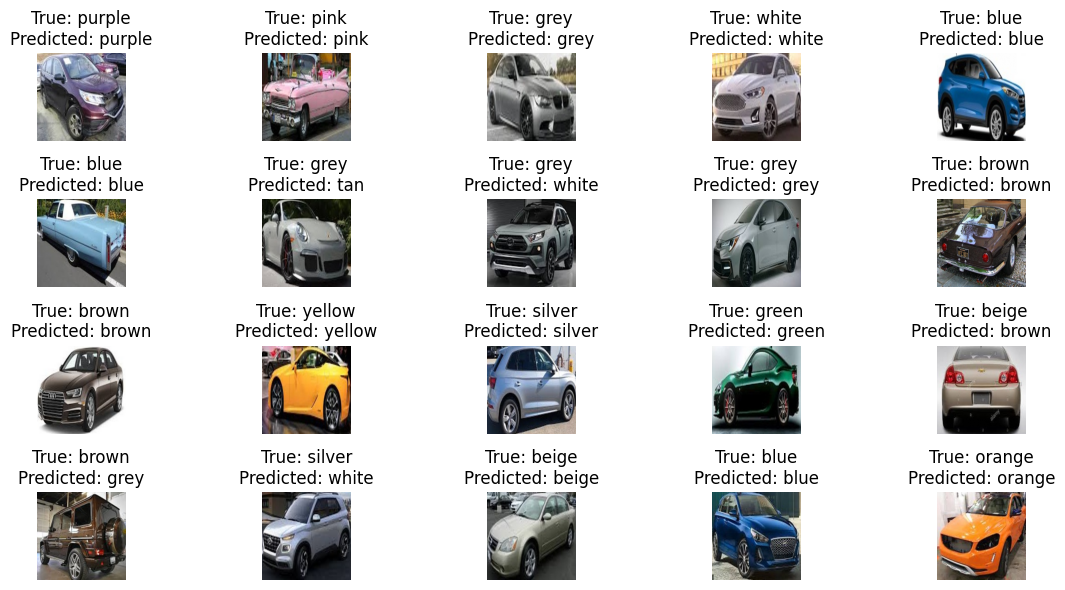

In [56]:
num_images = 20  # Number of random images to plot
random_indices = random.sample(range(len(test_images)), num_images) # Generates a list of num_images random indices from the test_images list.

# Predicting a probability vector
predictions = model.predict(test_images[random_indices]) # Uses the trained model to predict the labels for the randomly selected images by passing them to the model.predict() method.
y_pred = np.argmax(predictions, axis=-1) # Computes the predicted labels by finding the index with the highest probability for each prediction using np.argmax()

plt.figure(figsize=(12, 6))
for i, index in enumerate(random_indices): # Iterates over the random indices and their corresponding iteration number i.
    image = test_images[index] # retrieves the image corresponding to the current index.
    true_label = color_labels[test_labels[index]] #Retrieves the true label of the current image from the test_labels using index and maps it to the corresponding color label using the color_labels list.
    predicted_label = color_labels[y_pred[i]]

    plt.subplot(4, 5, i + 1)
    plt.imshow(image)
    plt.axis('off')
    plt.title(f'True: {true_label}\nPredicted: {predicted_label}')
plt.tight_layout()
plt.show()


In [57]:
## Using the model to make predictions
predictions = model.predict(test_images)
predicted_labels = predictions.argmax(axis=-1)

# Compute the confusion matrix
cm = confusion_matrix(predicted_labels, test_labels)
print("Confusion Matrix:")
print(cm)

clr = classification_report(test_labels, predicted_labels, target_names=color_labels)
print("Classification Report:\n----------------------\n", clr)

49/49 [==============================] - 14s 290ms/step
Confusion Matrix:
[[ 42   0   0   6   5   0   5   0   0   0   0   6  26   3   1]
 [  1  65   5   2   0   3   9   0   0   0   1   1   0   0   0]
 [  0   0 143   0   0   2   1   0   0   0   0   1   0   0   0]
 [ 13   9   2  88   8   3  11   2   0   2   0   4  11   0   0]
 [  4   0   1   2  14   0   0   0   0   0   0   0   2   0   5]
 [  0   0   1   0   0 108   0   0   0   0   0   1   0   0   0]
 [  2   9   1  11   2   2  53   0   0   1   0  15   3   1   0]
 [  0   1   0   7   7   0   1  91   0   0   0   0   0   1   8]
 [  0   0   0   0   0   0   0   0  86   1   2   0   1   0   0]
 [  0   3   3   2   0   1   2   0   3 109   0   0   0   0   0]
 [  0   0   0   0   0   2   0  19  11   1 133   0   0   0   0]
 [  1   0   2   0   0   0   3   0   0   1   0  31   0  10   0]
 [ 24   0   0   3   6   0   5   0   0   0   0   6  41   4   0]
 [  2   0   1   0   0   0   2   0   3   0   0  12   2  67   0]
 [  1   0   0   0   3   0   0   2   0   0   

In [58]:
# Compute the F1 score
f1 = f1_score(predicted_labels ,test_labels, average='macro')
print("F1 Score:", f1)

F1 Score: 0.7185029269739671


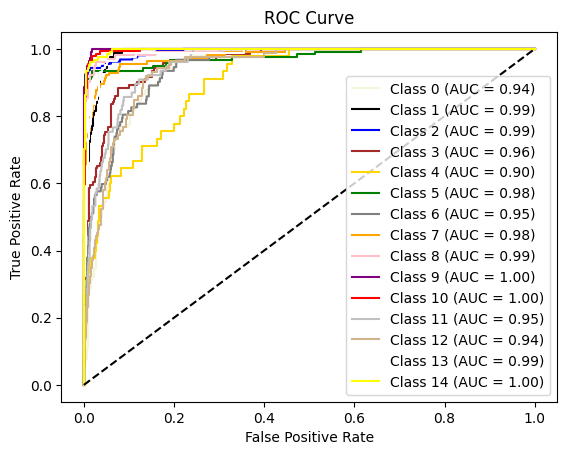

In [59]:
# Compute the ROC curve for each class
fpr = {}
tpr = {}
roc_auc = {}
num_classes = len(np.unique(test_labels))
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve((test_labels == i).astype(int), predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curve for each class
plt.figure()
colors = ['beige',
 'black',
 'blue',
 'brown',
 'gold',
 'green',
 'grey',
 'orange',
 'pink',
 'purple',
 'red',
 'silver',
 'tan',
 'white',
 'yellow']  # Add more colors if you have more classes
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i], label='Class {} (AUC = {:.2f})'.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()